# Unet with Tversky loss

## 10/03/21

Asymetric loss functions are an approach to force a semantic segmenter to focus on a rare set of pixels (in this case eggs). One such function is [Tversky loss](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8573779) that can be forumlated as:

$$
    T(\alpha, \beta) = \frac{tp}{tp + \alpha*fp + \beta*fn}
$$

In [1]:
%matplotlib inline

import os
import glob
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import cv2
import segmentation_models_pytorch as smp
from utils.datatools import PlanktonDataset
from utils.transform_helpers import *
from utils.visualizers import visualize
from utils.custom_loss import TverskyLoss

### Preliminaries
Point to the dataset split by profile for the ResNet training a few weeks ago, desired network, encoder depth, etc.

In [2]:
# file paths
vocpath = '/home/eorenstein/VOCCopepodEgg'
imgset = 'SplitByProfile-230221'

# Unet settings
ENCODER = 'resnet18'
WEIGHTS = 'imagenet'
DEPTH = 5  # desired depth of encoder. default is 5 for resnet-18
DECODE_CHAN = (256, 128, 64, 32, 16)  # must set corresponding filter sizes of decoder. length must match depth
CHANNELS = 3  # set as 1 for gray, 3 for color
ACTIVE = 'softmax2d'
CLASSES = ['copepod', 'eggs']
n_classes = 1 if len(CLASSES) == 1 else ((len(CLASSES) + 1))

### Instatiate model

In [3]:
if DEPTH == 5:
    model = smp.Unet(
        encoder_name=ENCODER,
        encoder_weights=WEIGHTS,
        in_channels=CHANNELS,  
        classes=n_classes,
        activation=ACTIVE
    )
else:
    model = smp.Unet(
        encoder_name=ENCODER,
        encoder_weights=WEIGHTS,
        encoder_depth=DEPTH,
        decoder_channels=DECODE_CHAN,
        in_channels=CHANNELS,  
        classes=n_classes,
        activation=ACTIVE
    )

# this is the preprocessing for imagenet if using 3 channel images
if CHANNELS == 3:
    preprocess = smp.encoders.get_preprocessing_fn(ENCODER, WEIGHTS)
    dmy_clf = True
else:
    preprocess = None
    dmy_clf = False

### Get datasets and loaders

Since only interested in egg data point to that train and val set. 

In [4]:
training_dataset = PlanktonDataset(root=vocpath,
                                   img_set=f'{imgset}/egg_train.txt',
                                   augs=training_transform(),
                                   preproc=get_preprocessing(preprocess),
                                   classes=CLASSES,
                                   dummy_clf=dmy_clf
                                  )

val_dataset = PlanktonDataset(root=vocpath,
                              img_set=f'{imgset}/egg_val.txt',
                              augs=validation_transform(),
                              preproc=get_preprocessing(preprocess),
                              classes=CLASSES,
                              dummy_clf=dmy_clf
                             )

# check that the lengths are consistent
print('train set:', len(training_dataset), 'images')
print('val set:', len(val_dataset), 'images')

train_loader = DataLoader(training_dataset, batch_size=8, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=1)

train set: 1330 images
val set: 313 images


### Define loss function

This is where the loss function is defined. Try out the custom Tversky loss just on the egg channel (ignore the without-egg and background channel).

In [5]:
loss = TverskyLoss(ignore_channels=[0,2])

metrics = [
    smp.utils.metrics.IoU(threshold=0.5, ignore_channels=[0,2]),
    smp.utils.metrics.Fscore(threshold=0.5, ignore_channels=[1, 2]),
    smp.utils.metrics.Accuracy(threshold=0.5, ignore_channels=[1, 2])
]

# standard atom optimizer from PyTorch (might want to consider reducing the learning rate)
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

### Define the epoch runners

In [6]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device='cuda',
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device='cuda',
    verbose=True,
)

### Training cycle

In [7]:
max_score = 0

# where to save
outpath = '/home/eorenstein/python_code/eggs-emantic/clf-outputs'
descript = 'eggs_only_tversky'  # info about model

for i in range(0, 15):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(val_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, os.path.join(outpath,f'{descript}_best_model.pth'))
        print('Model saved!')
        
    if max_score > 0.94:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 313/313 [00:02<00:00, 113.34it/s, tversky_loss - 0.461, iou_score - 0.3892, fscore - 0.01859, accuracy - 0.5262] 
Model saved!

Epoch: 1
valid: 100%|██████████| 313/313 [00:02<00:00, 112.23it/s, tversky_loss - 0.3595, iou_score - 0.4452, fscore - 0.04419, accuracy - 0.526] 
Model saved!

Epoch: 2
valid: 100%|██████████| 313/313 [00:02<00:00, 121.26it/s, tversky_loss - 0.3017, iou_score - 0.611, fscore - 0.08842, accuracy - 0.5751] 
Model saved!

Epoch: 3
valid: 100%|██████████| 313/313 [00:02<00:00, 110.86it/s, tversky_loss - 0.2321, iou_score - 0.633, fscore - 0.08654, accuracy - 0.583]  
Model saved!

Epoch: 4
valid: 100%|██████████| 313/313 [00:02<00:00, 111.76it/s, tversky_loss - 0.2184, iou_score - 0.654, fscore - 0.08247, accuracy - 0.606]  
Model saved!

Epoch: 5
valid: 100%|██████████| 313/313 [00:02<00:00, 115.63it/s, tversky_loss - 0.2053, iou_score - 0.6595, fscore - 0.09154, accuracy - 0.5781]
Model saved!

Epoch: 6
valid: 100%|██████████| 

### Evaluate on the independent test set

In [8]:
# this is for running images through the classifier
test_dataset = PlanktonDataset(root=vocpath, 
                               img_set=f'{imgset}/egg_test.txt',
                               augs=validation_transform(),
                               preproc=get_preprocessing(preprocess),
                               classes=CLASSES,
                               dummy_clf=dmy_clf)

# this does not do any preprocessing for plotting
test_viz = PlanktonDataset(root=vocpath, 
                           img_set=f'{imgset}/egg_test.txt',
                           classes=CLASSES,
                           )

Evaluate the model on all the images of the test set.

In [14]:
best_model = torch.load(f'./clf-outputs/{descript}_best_model.pth')

metrics = [
    smp.utils.metrics.IoU(threshold=0.5, ignore_channels=[0, 1]),
    smp.utils.metrics.Fscore(threshold=0.5, ignore_channels=[0, 1]),
    smp.utils.metrics.Accuracy(threshold=0.5, ignore_channels=[0, 1])
]


test_dataloader = DataLoader(test_dataset)

test_epoch = smp.utils.train.ValidEpoch(
    best_model, 
    loss=loss, 
    metrics=metrics, 
    device='cuda',
    verbose=True,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 266/266 [00:02<00:00, 123.23it/s, tversky_loss - 0.2067, iou_score - 0.5728, fscore - 0.7261, accuracy - 0.5937]


## Evaluate on images without eggs

Load in images without eggs to see what it does. First grab a list of image-ids of just copepods.

In [20]:
with open('/home/eorenstein/VOCCopepodEgg/ImageSets/Main/SplitByProfile-230221/cope_test.txt', 'r') as ff:
    copes = list(ff)
    ff.close()
    
copes = [line.strip() for line in copes]
print(len(copes))

13458


There are more in there than we care to process. Select a random 1000.

In [21]:
np.random.shuffle(copes)
copes = copes[0:1000]

Load them as a dataset and procede as above

In [22]:
# this is for running images through the classifier
cope_dataset = PlanktonDataset(root=vocpath, 
                               img_set=copes,
                               augs=validation_transform(),
                               preproc=get_preprocessing(preprocess),
                               classes=CLASSES,
                               dummy_clf=dmy_clf)

# this does not do any preprocessing for plotting
cope_viz = PlanktonDataset(root=vocpath, 
                           img_set=copes,
                           classes=CLASSES,
                           )

Re-instantiate in case not loaded and evaluate the model on all the images of the test set.

In [27]:
metrics = [
    smp.utils.metrics.IoU(threshold=0.5, ignore_channels=[0, 1]),
    smp.utils.metrics.Fscore(threshold=0.5, ignore_channels=[0, 1]),
    smp.utils.metrics.Accuracy(threshold=0.5, ignore_channels=[0, 1])
]

cope_dataloader = DataLoader(cope_dataset)

cope_epoch = smp.utils.train.ValidEpoch(
    best_model, 
    loss=loss, 
    metrics=metrics, 
    device='cuda',
    verbose=True,
)

logs = cope_epoch.run(cope_dataloader)

valid: 100%|██████████| 1000/1000 [00:08<00:00, 113.61it/s, tversky_loss - 1.0, iou_score - 0.5655, fscore - 0.7175, accuracy - 0.5849]


In [31]:
egg_px = []
cope_px = []
num = 0

for jj in range(len(cope_dataset)):
    img, mask = cope_dataset[jj]

    mask = mask.squeeze()

    # put it on the GPU
    imgtens = torch.from_numpy(img).to('cuda').unsqueeze(0)
    pred = best_model.predict(imgtens)
    pred = (pred.squeeze().cpu().numpy().round())
    
    egg_px.append(np.sum(pred[1, :, :]))
    cope_px.append(np.sum(pred[0, :, :]))
    
    if np.sum(pred[1, :, :]) < 50:
        num+=1
"""
fig, ax = plt.subplots(1,2, figsize=(16, 5))
ax[0].hist([egg_px, cope_px])
ax[1].hist(cope_px)
"""
print(num)

38


(array([161., 314., 283., 128.,  72.,  23.,  10.,   5.,   2.,   2.]),
 array([   0. ,  141.3,  282.6,  423.9,  565.2,  706.5,  847.8,  989.1,
        1130.4, 1271.7, 1413. ], dtype=float32),
 <BarContainer object of 10 artists>)

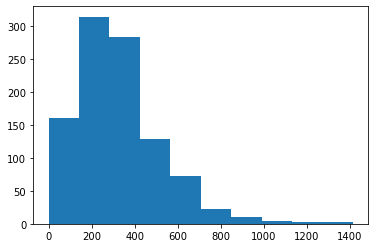

In [30]:
plt.hist(egg_px)